In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

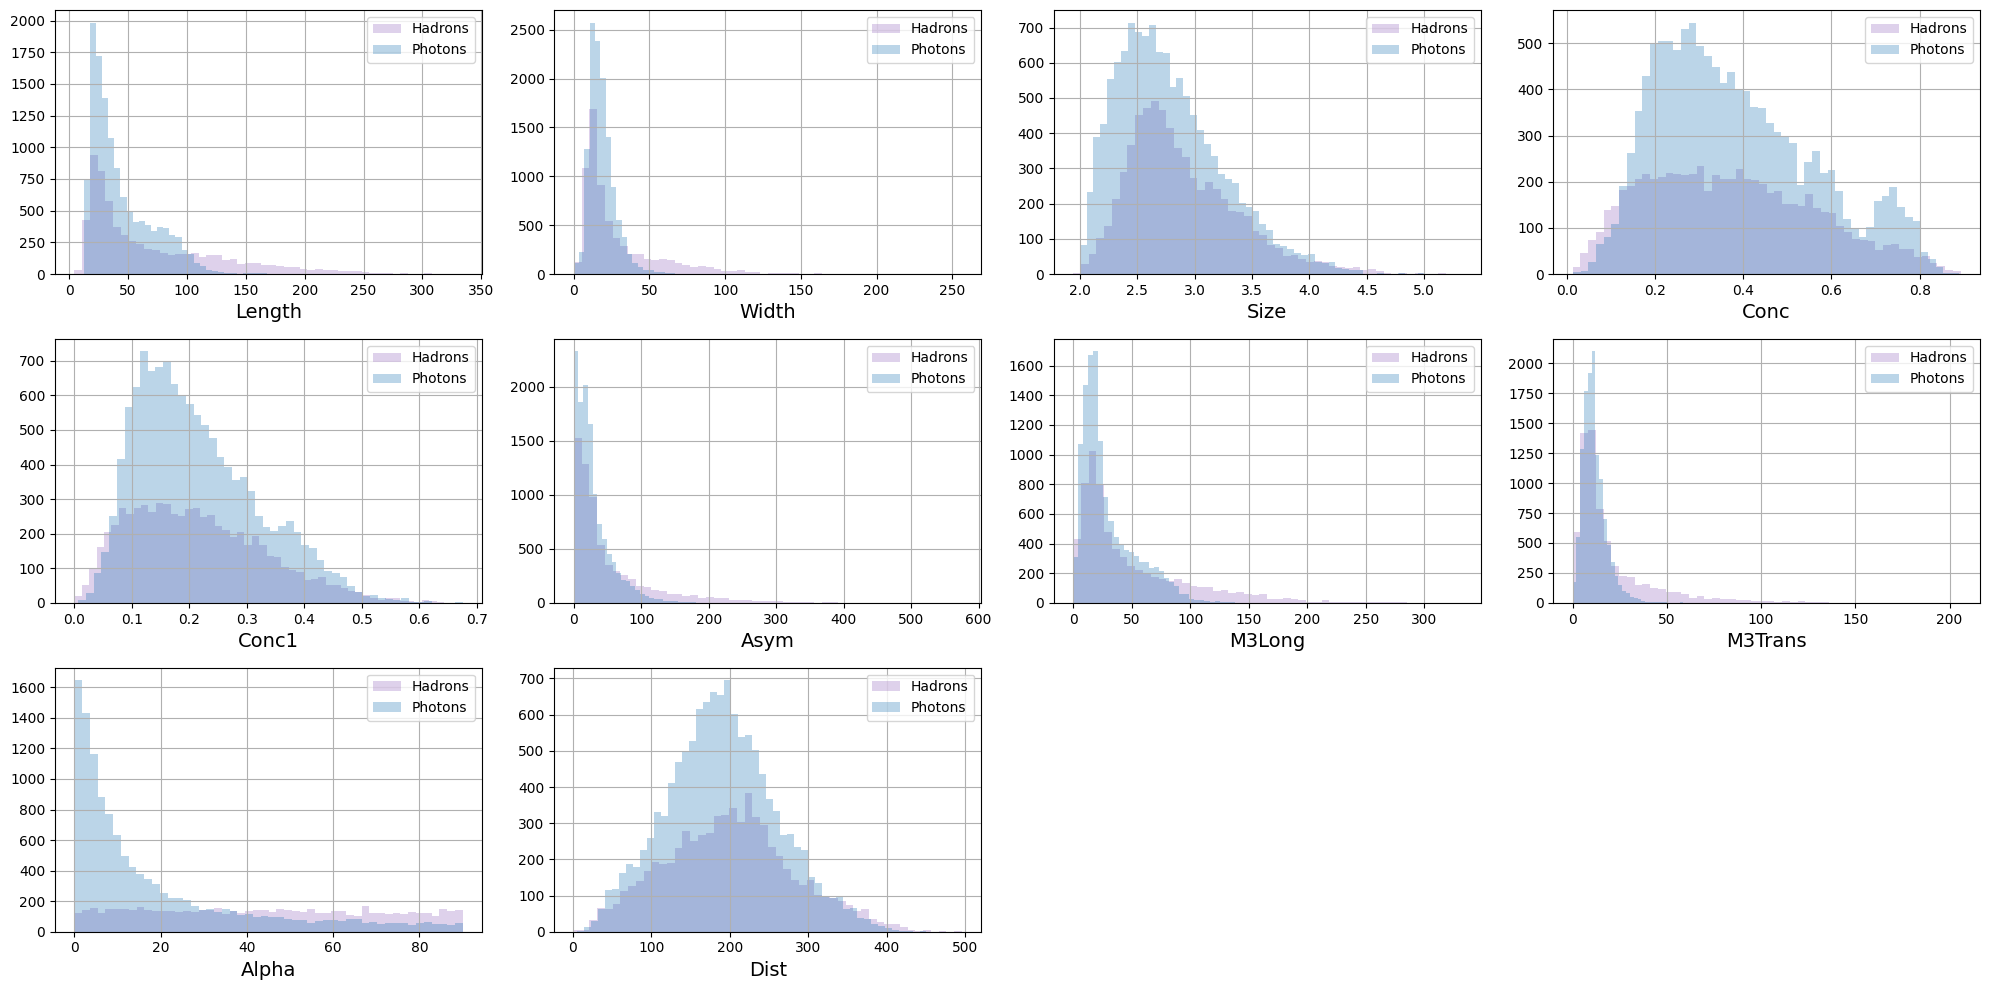

In [9]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Обучающая и тестовая выборки

In [10]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

In [12]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

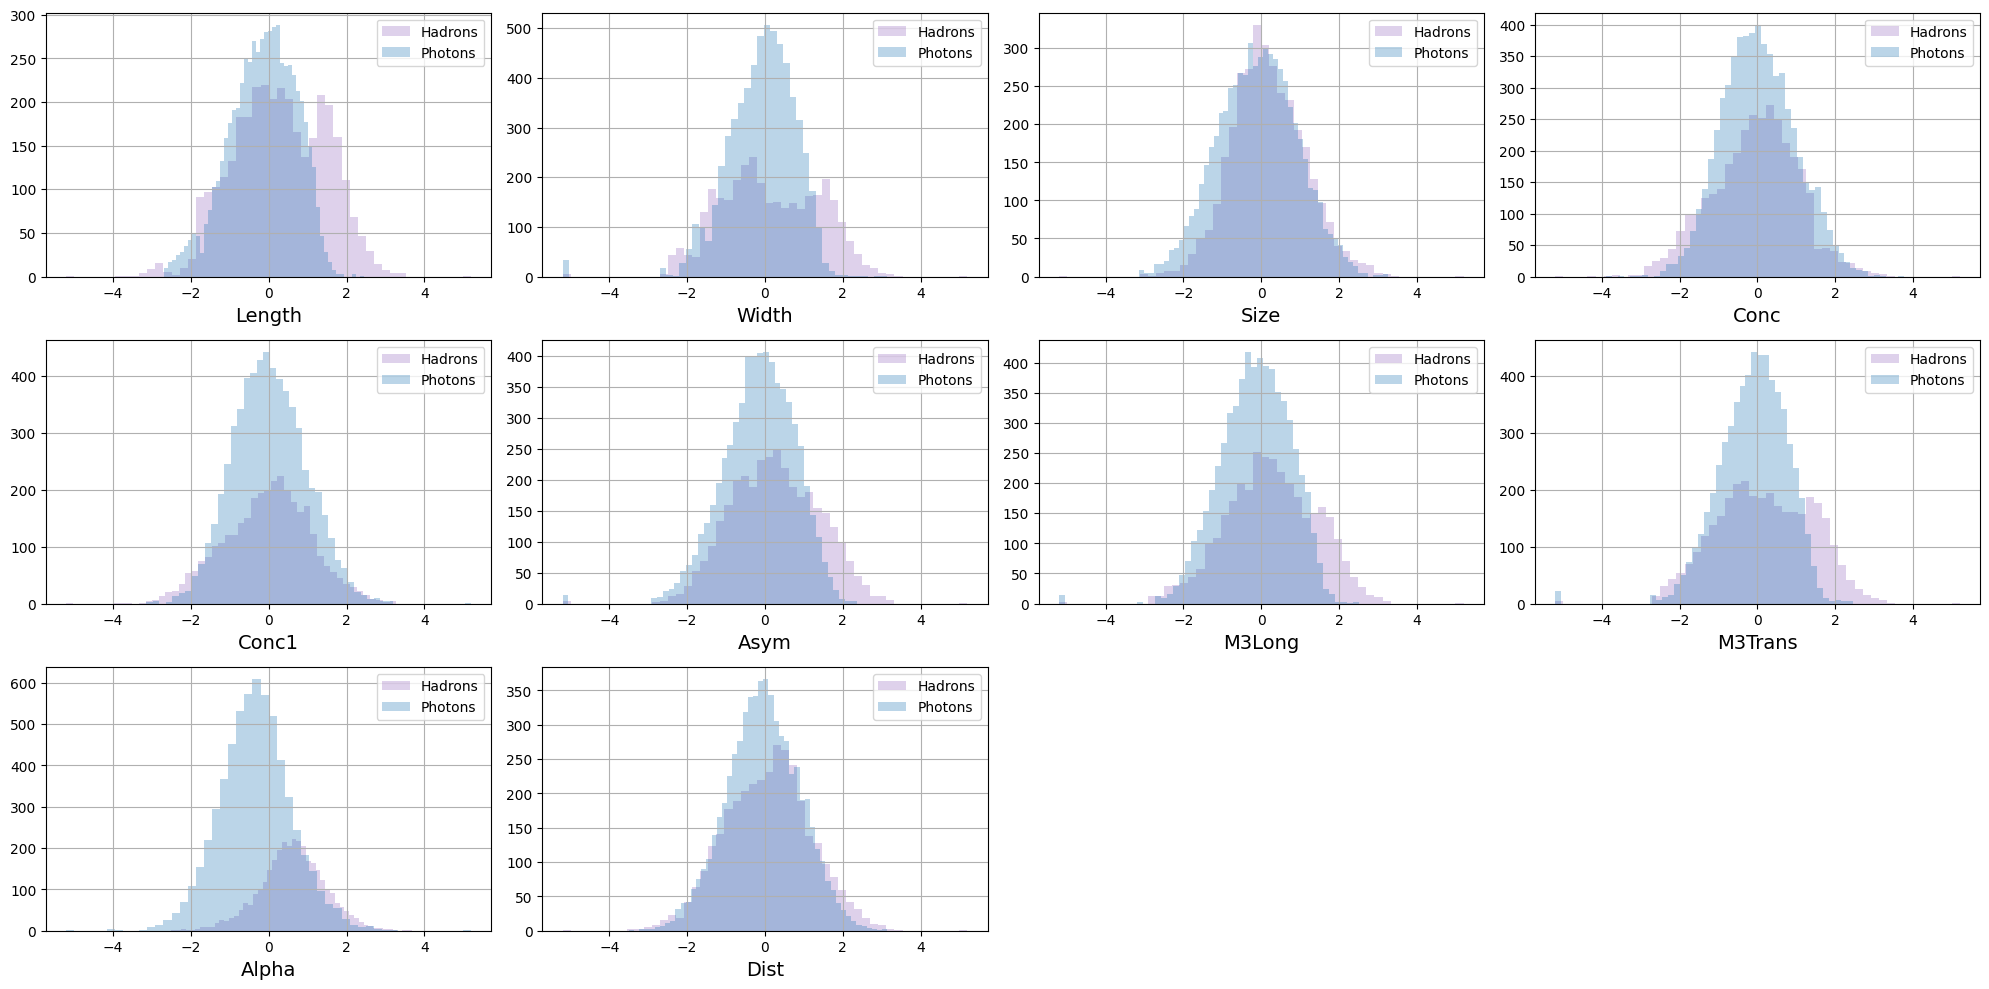

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

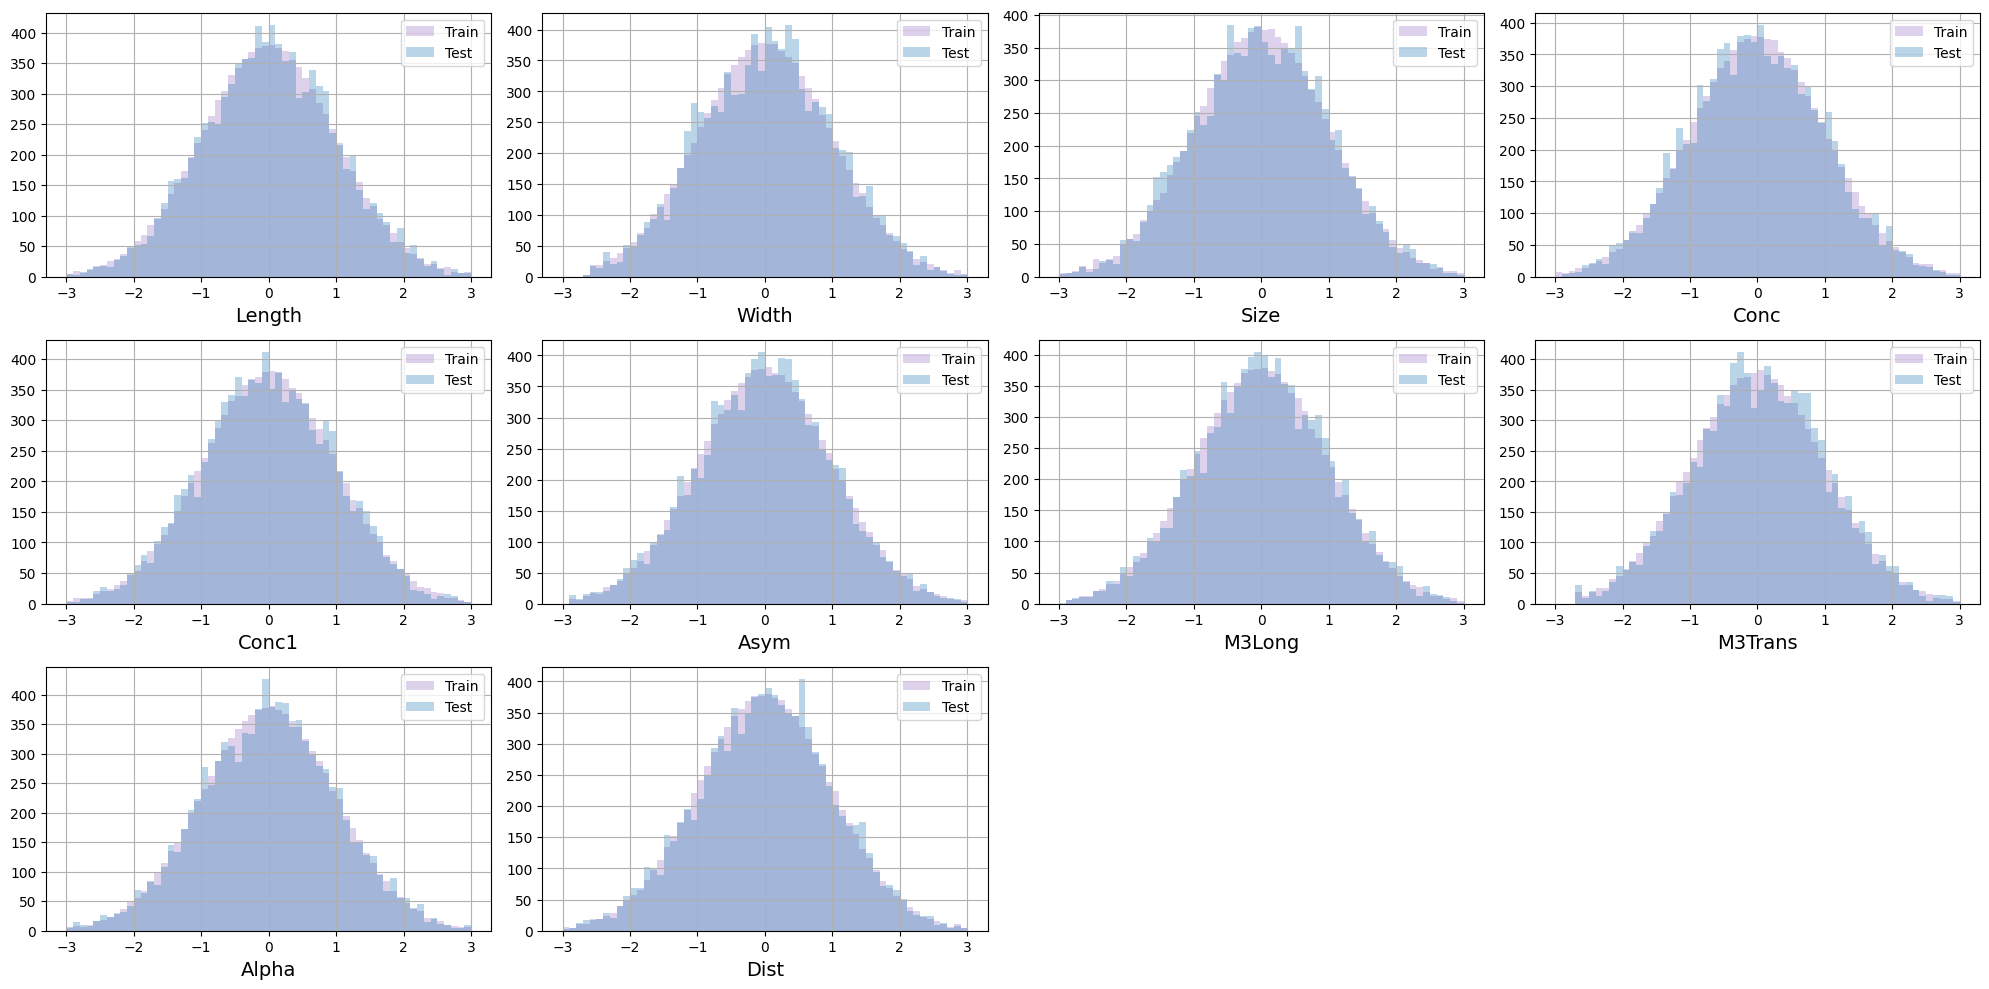

In [14]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
DEVICE

device(type='cuda')

In [16]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.rl1 = nn.ReLU()

        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.rl2 = nn.ReLU()

        self.last = nn.Linear(100, n_outputs)


    def forward(self, z, y):
        zy = torch.cat((z.cuda(), y.cuda()), dim=1)

        x1 = self.rl1((self.bn1(self.fc1(zy))))

        x2 = self.rl2((self.bn2(self.fc2(x1))))

        return self.last(x2)

In [17]:
def generate(generator, y, latent_dim):

    X_fake = generator(torch.normal(0, 1, size=(len(y), latent_dim)), y).detach().cpu().numpy()
    return X_fake

In [18]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.rl1 = nn.ReLU()

        self.fc2 = nn.Linear(100, 100)
        self.rl2 = nn.ReLU()

        self.last = nn.Linear(100, 1)
        self.act = nn.Sigmoid()

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)

        res = self.rl1(self.fc1(xy))

        res = self.rl2(self.fc2(res))

        return self.act(self.last(res))

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    log_reg = LogisticRegression()
    boosting = GradientBoostingClassifier()
    log_reg.fit(X_train, y_train)
    boosting.fit(X_train, y_train)

    lin_reg_score = accuracy_score(y_test, log_reg.predict(X_test))
    boosting_score = accuracy_score(y_test, boosting.predict(X_test))

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

In [15]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max_wpeg (max_wpeg-hse). Use `wandb login --relogin` to force relogin


True

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

        wandb.init(project="komarov_GAN", config={
            "batch_size": batch_size,
            "n_epochs": n_epochs,
            "latent_dim": latent_dim,
            "lr": lr,
            "n_critic": n_critic
        })
        wandb.watch(self.generator, log="gradients", log_freq=10)
        wandb.watch(self.discriminator, log="gradients", log_freq=10)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                z = torch.normal(0, 1, size=(real_batch.shape[0], self.latent_dim))
                gen_batch = self.generator(z, cond_batch)

                real_scores = self.discriminator(real_batch, cond_batch)
                gen_scores = self.discriminator(gen_batch, cond_batch)

                if i % (self.n_critic + 1) == 0:
                    self.opt_gen.zero_grad()
                    gen_loss = -torch.mean(gen_scores)
                    gen_loss.backward()
                    self.opt_gen.step()
                    wandb.log({"gen_loss": gen_loss.item(), "epoch": epoch, "step": i})
                else:
                    self.opt_disc.zero_grad()
                    disc_loss = -torch.mean(real_scores) + torch.mean(gen_scores)
                    disc_loss.backward()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    self.opt_disc.step()
                    wandb.log({"disc_loss": disc_loss.item(), "epoch": epoch, "step": i})


            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            wandb.log({"epoch_loss": loss_epoch.item(), "epoch": epoch})
            self.loss_history.append(loss_epoch.detach().cpu())

            real_1000 = X_real[:1000].to(DEVICE)
            z_1000 = torch.normal(0, 1, (1000, self.latent_dim), device=DEVICE)
            gen_1000 = self.generator(z_1000, y_cond[:1000])
            other_agent_score(real_1000.cpu().detach().numpy(), torch.ones(1000), gen_1000.cpu().detach().numpy(), torch.zeros(1000))

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

        wandb.finish()

## Обучение

In [26]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.742
Boosting score: 0.972
Linear regression score: 0.626
Boosting score: 0.946
Linear regression score: 0.542
Boosting score: 0.902
Linear regression score: 0.532
Boosting score: 0.876
Linear regression score: 0.56
Boosting score: 0.888
Linear regression score: 0.526
Boosting score: 0.906
Linear regression score: 0.512
Boosting score: 0.89
Linear regression score: 0.56
Boosting score: 0.864
Linear regression score: 0.55
Boosting score: 0.858
Linear regression score: 0.558
Boosting score: 0.808
Linear regression score: 0.526
Boosting score: 0.792
Linear regression score: 0.568
Boosting score: 0.766
Linear regression score: 0.518
Boosting score: 0.748
Linear regression score: 0.55
Boosting score: 0.732
Linear regression score: 0.504
Boosting score: 0.75
Linear regression score: 0.502
Boosting score: 0.708
Linear regression score: 0.524
Boosting score: 0.722
Linear regression score: 0.546
Boosting score: 0.678
Linear regression score: 0.558
Boosting score: 0.702

disc_loss,▁▄▃▅▆▅▅▅▅▅▅▆▆▇▅▆▆▇▆▆▆▇▇▇▇▇▆█▇▆▆▆▇▇▆▇▆▇▇▇
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██████
epoch_loss,▆█▇▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gen_loss,█▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▃▃▂▂▃▂▁▂▂▂▃▃▃▃▂▂▂▂▃▂▁▁▂
step,█▆▃▆▂▂▄▂▄▅▅▇▅▁▄█▃▇▂▅▇▂▅▇▄▅▆▂▅▆▁▆▇▇█▅▁▂▂▆
disc_loss,-9e-05
epoch,99
epoch_loss,3e-05
gen_loss,-0.5001
step,190


CPU times: total: 2min 10s
Wall time: 2min 17s


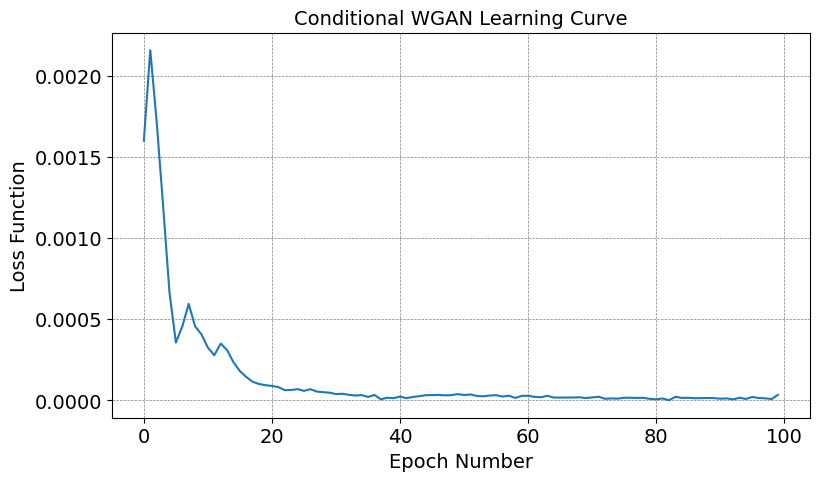

In [27]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

[wandb](https://api.wandb.ai/links/max_wpeg-hse/04tiq556)


In [28]:
X_fake_train = generate(fitter.generator, torch.tensor(y_train).float(), latent_dim)
X_fake_train_tr = qt.inverse_transform(X_fake_train)
X_train_tr = qt.inverse_transform(X_train)

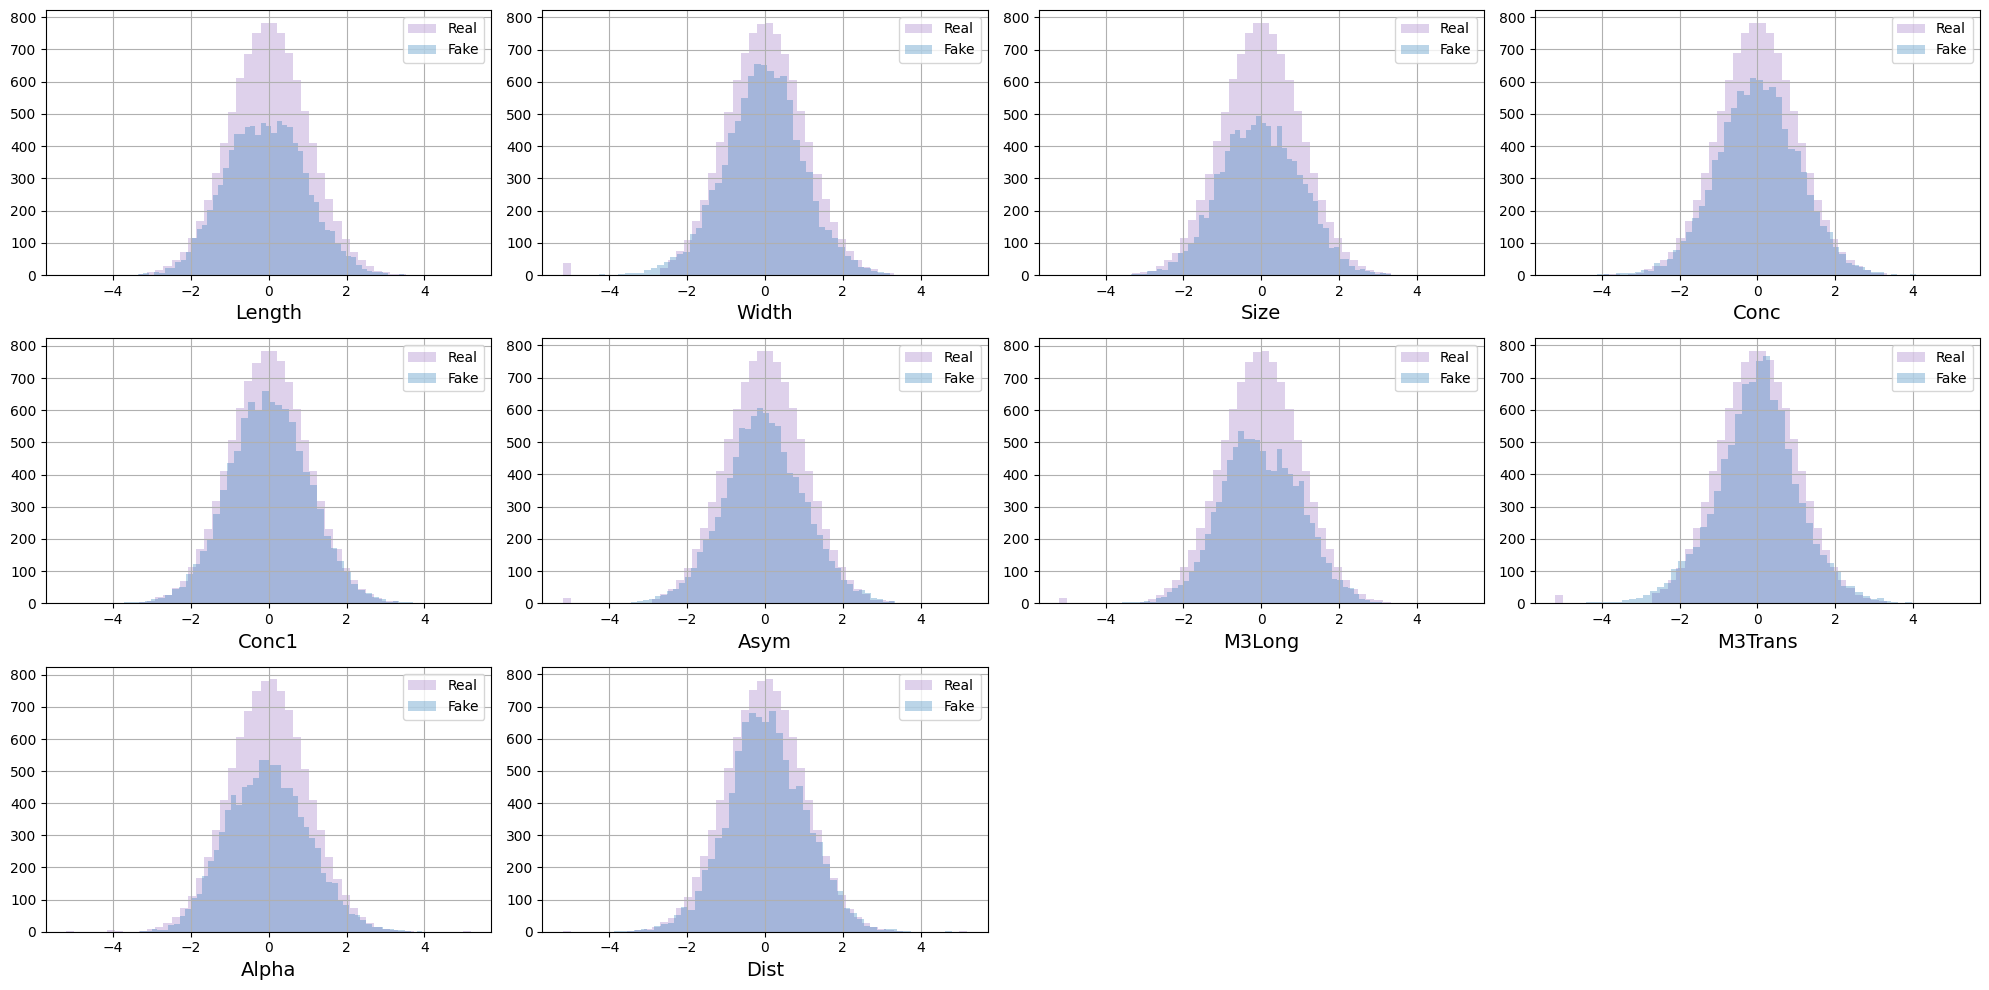

In [29]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [30]:
X_fake_test = generate(fitter.generator, torch.tensor(y_test).float(), latent_dim)
X_fake_test_tr = qt.inverse_transform(X_fake_test)
X_test_tr = qt.inverse_transform(X_test)

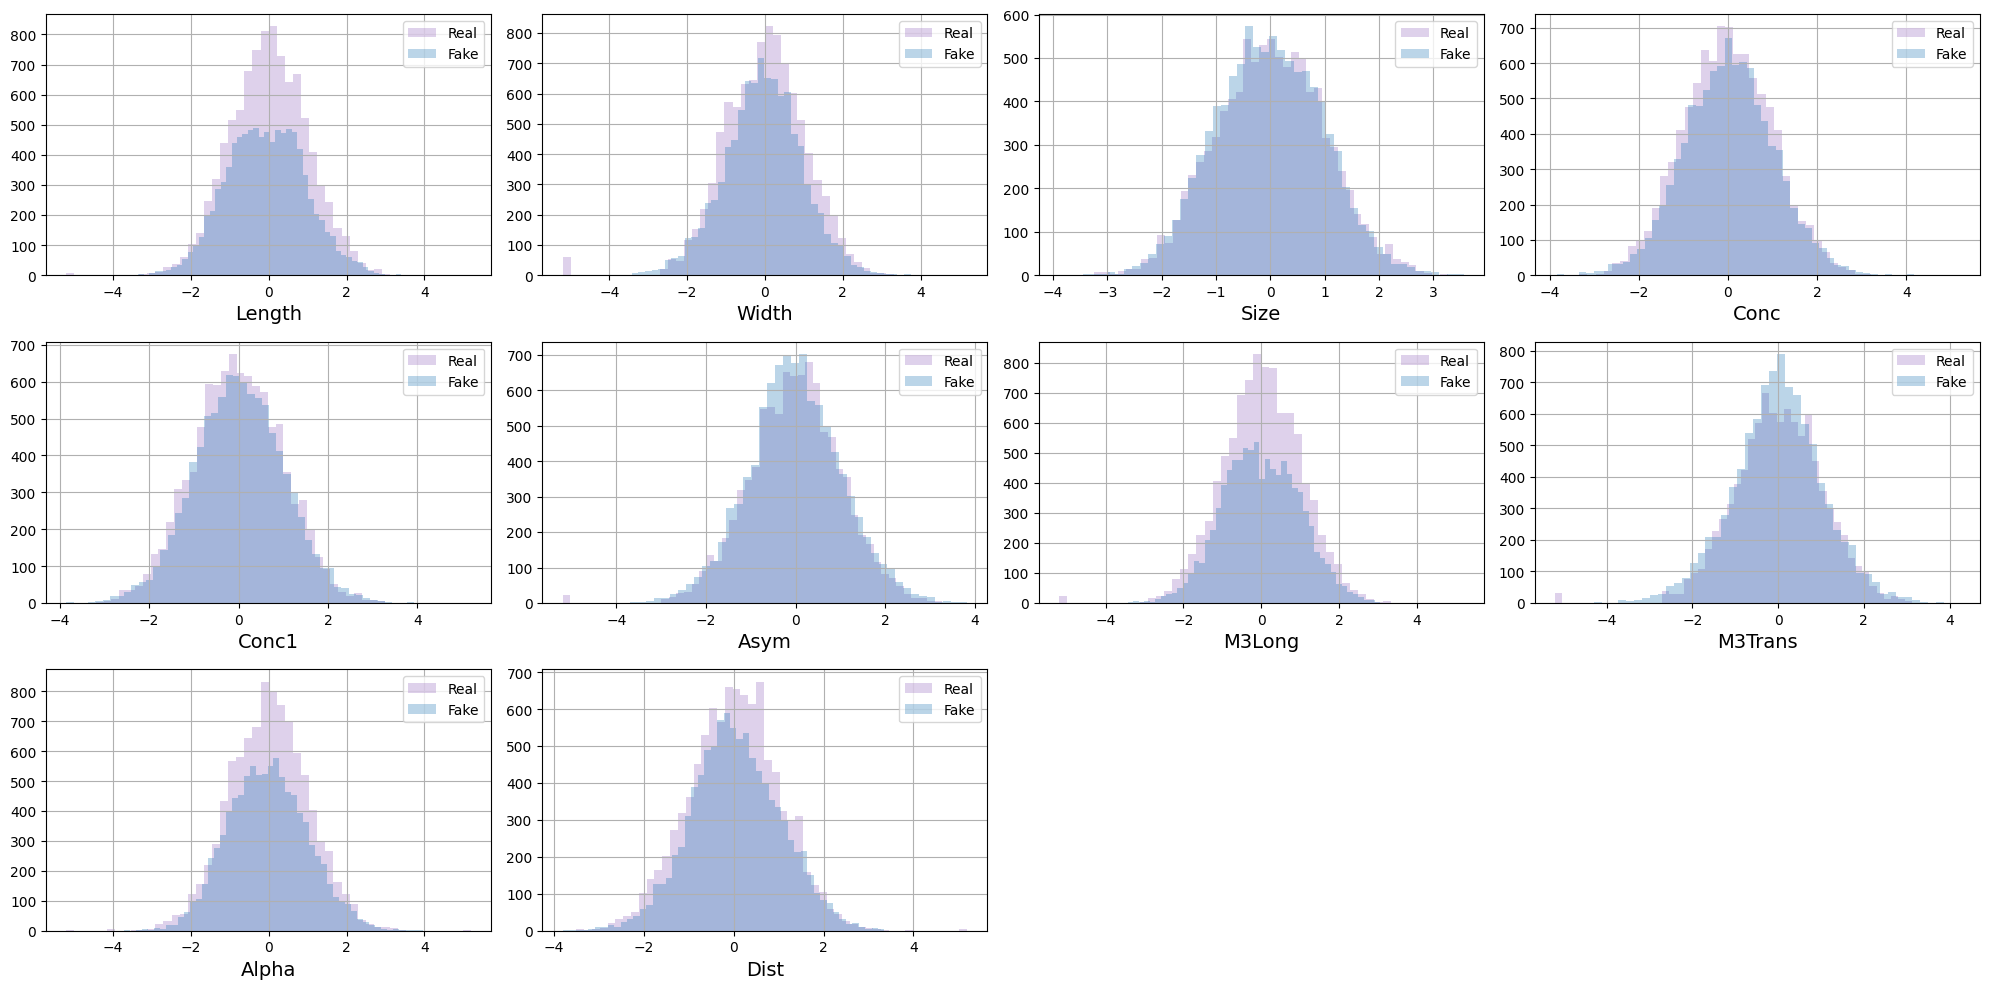

In [31]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/clf.png?raw=true" width="600"></center>

Измерим сходство распределений классификатором.

In [32]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [34]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.703394523004729


## Диффузионные модели.


In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.rl1 = nn.ReLU()

        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.rl2 = nn.ReLU()

        self.last = nn.Linear(100, n_outputs)

    def forward(self, z, t, y):

        inp = torch.cat([z, t.unsqueeze(1), y], dim=1)

        x1 = self.rl1(self.bn1(self.fc1(inp)))

        x2 = self.rl2(self.bn2(self.fc2(x1)))

        return self.last(x2)

In [37]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    X_fake = torch.randn((y.shape[0], latent_dim)).to(DEVICE)
    for t in scheduler.timesteps:
        t_tensor = torch.full((y.shape[0],), t, device=DEVICE, dtype=torch.long)
        with torch.no_grad():
            noise_pred = model(X_fake, t_tensor, y.cuda())
        X_fake = scheduler.step(noise_pred, t, X_fake).prev_sample
    return X_fake.cpu().numpy()

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

        self.loss_fn = nn.MSELoss()

        wandb.init(project="komarov_Diffusion", config={
            "batch_size": batch_size,
            "n_epochs": n_epochs,
            "latent_dim": latent_dim,
            "lr": lr,
            "n_critic": n_critic
        })
        wandb.watch(self.model, log="gradients", log_freq=10)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit Diffusion
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0], )).long().to(DEVICE)
                noisy_x = noise_scheduler.add_noise(real_batch, noise, timesteps)
                
                pred = self.model(noisy_x, timesteps, cond_batch)

                loss = self.loss_fn(pred, noise)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                wandb.log({"loss": loss.item(), "epoch": epoch, "step": i})
                loss_epoch += loss.item() / X_real.shape[0]

            # calculate and store loss after an epoch

            wandb.log({"epoch_loss": loss_epoch, "epoch": epoch})
            self.loss_history.append(loss_epoch)

            real_1000 = X_real[:1000].to(DEVICE)
            noise_1000 = torch.randn_like(real_1000)
            timesteps_1000 = torch.randint(0, 999, (real_1000.shape[0], )).long().to(DEVICE)
            noisy_x_1000 = noise_scheduler.add_noise(real_1000, noise_1000, timesteps_1000)
            gen_1000 = self.model(noisy_x_1000, timesteps_1000, y_cond[:1000])
            other_agent_score(real_1000.cpu().detach().numpy(), torch.ones(1000), gen_1000.cpu().detach().numpy(), torch.zeros(1000))


        # Turn off training
        self.model.train(False)
        wandb.finish()

In [40]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + 1 + y.shape[1],
                           n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.488
Boosting score: 0.978
Linear regression score: 0.49
Boosting score: 0.96
Linear regression score: 0.482
Boosting score: 0.934
Linear regression score: 0.522
Boosting score: 0.928
Linear regression score: 0.434
Boosting score: 0.904
Linear regression score: 0.506
Boosting score: 0.922
Linear regression score: 0.504
Boosting score: 0.914
Linear regression score: 0.462
Boosting score: 0.936
Linear regression score: 0.474
Boosting score: 0.92
Linear regression score: 0.47
Boosting score: 0.912
Linear regression score: 0.52
Boosting score: 0.888
Linear regression score: 0.516
Boosting score: 0.91
Linear regression score: 0.492
Boosting score: 0.922
Linear regression score: 0.518
Boosting score: 0.928
Linear regression score: 0.498
Boosting score: 0.912
Linear regression score: 0.504
Boosting score: 0.924
Linear regression score: 0.51
Boosting score: 0.93
Linear regression score: 0.494
Boosting score: 0.914
Linear regression score: 0.482
Boosting score: 0.92
Li

epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇███
epoch_loss,█▆▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▃▄▃▂▁▃▂▃▁▂▂▂▂▂▂▂▂▂▁▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂
step,▅▄▇▃▇▆▄▂▆▇▁▃▄▅▇▆▁█▅▄▁▁▂▂█▂▅▁▆▇▆█▆▁▂▄█▅▅▂
epoch,99
epoch_loss,0.00489
loss,0.34195
step,190


CPU times: total: 2min 3s
Wall time: 2min 12s


[wandb report](https://api.wandb.ai/links/max_wpeg-hse/42v7vop7)

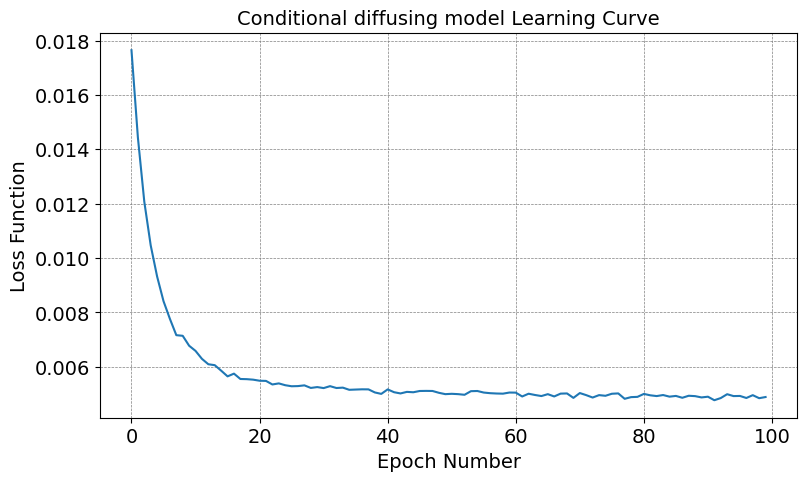

In [41]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [42]:
X_fake_train_diffusion = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_train).float(), latent_dim, noise_scheduler)
X_fake_train_diffusion_tr = qt.inverse_transform(X_fake_train_diffusion)
X_train_tr = qt.inverse_transform(X_train)

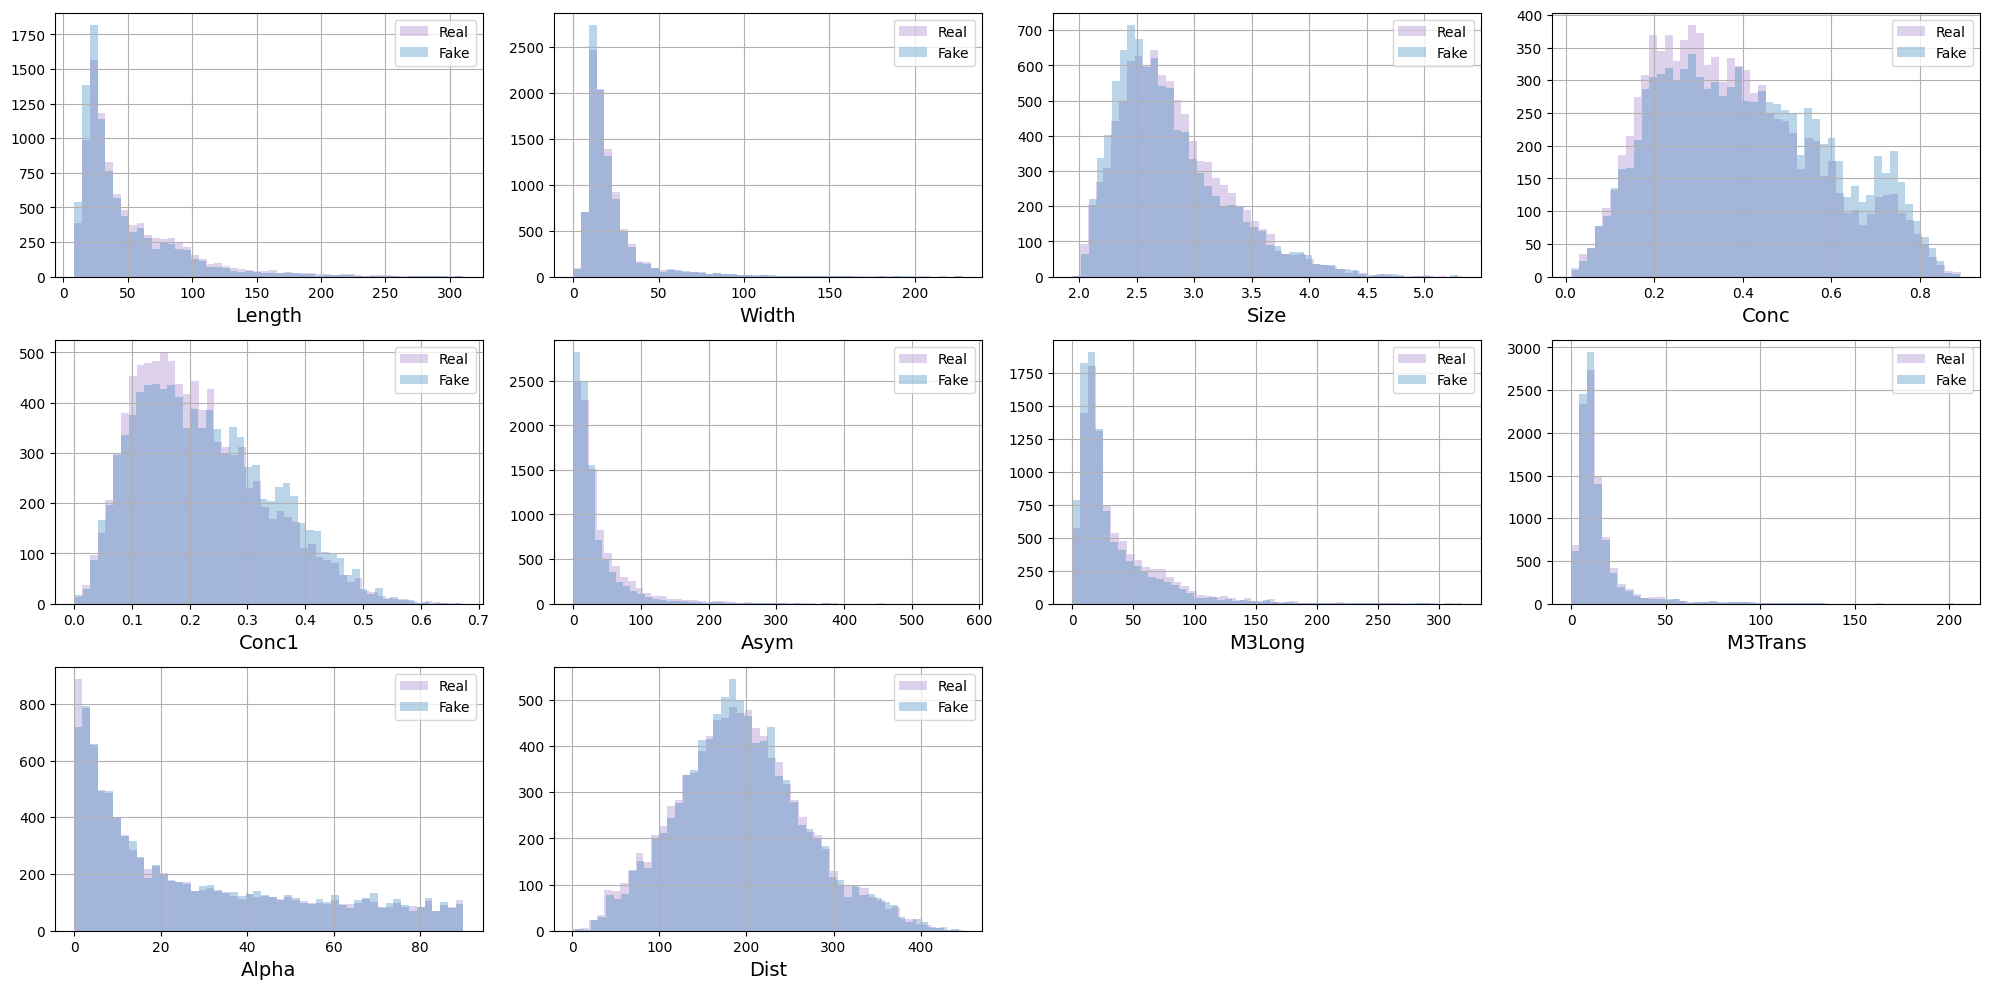

In [43]:
plot_hists(X_train_tr, X_fake_train_diffusion_tr, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test_diffusion = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_test).float(), latent_dim, noise_scheduler)
X_fake_test_diffusion_tr = qt.inverse_transform(X_fake_test_diffusion)
X_fake_test_diffusion_tr = qt.inverse_transform(X_fake_test_diffusion)

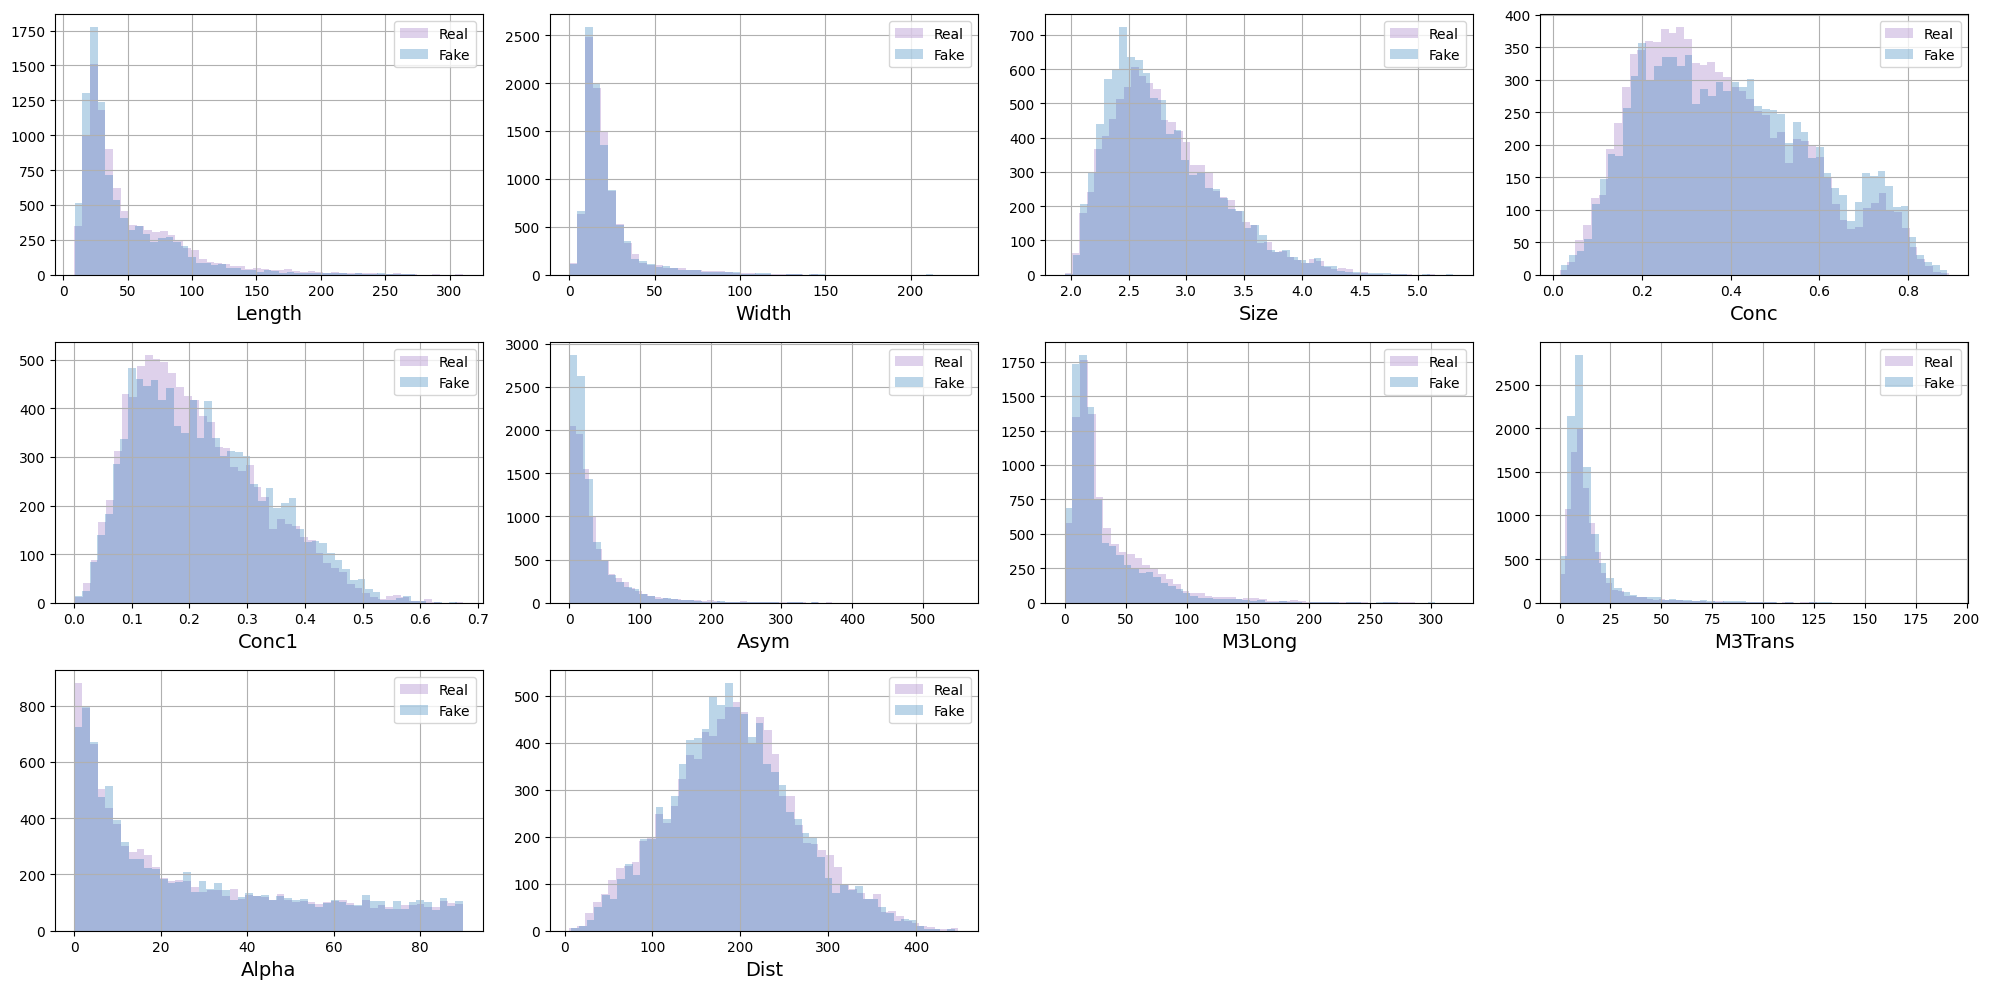

In [ ]:
plot_hists(X_test_tr, X_fake_test_diffusion_tr, names, label1="Real", label2="Fake", bins=50)

In [48]:
XX_train_diffusion = np.concatenate((X_fake_train_diffusion, X_train), axis=0)
XX_test_diffusion = np.concatenate((X_fake_test_diffusion, X_test), axis=0)

In [49]:
yy_train = np.array([0] * len(X_fake_train_diffusion) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test_diffusion) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf_diffusion = GradientBoostingClassifier()
clf_diffusion.fit(XX_train_diffusion, yy_train)

yy_test_proba_diffusion = clf_diffusion.predict_proba(XX_test_diffusion)[:, 1]

In [53]:
from sklearn.metrics import roc_auc_score, accuracy_score

auc_diffusion = roc_auc_score(yy_test, yy_test_proba_diffusion)
acc_diffusion = accuracy_score(yy_test, (yy_test_proba_diffusion >= 0.5).astype(int))

print("ROC AUC = ", auc_diffusion)
print("accuracy = ", acc_diffusion)

ROC AUC =  0.7046073478468069
accuracy =  0.6401156677181914


# VAE

In [19]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()   
        )

        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100), 
            nn.ReLU(), 
            nn.Linear(100, 100), 
            nn.ReLU(), 
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

def generate_with_vae(decoder, y, latent_dim):
    
    X_fake = decoder(torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE), torch.tensor(y).float().to(DEVICE)).detach().cpu().numpy()

    return X_fake  # numpy

In [20]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

        wandb.init(project="komarov_VAE", config={
            "batch_size": batch_size,
            "n_epochs": n_epochs,
            "latent_dim": latent_dim,
            "lr": lr
        })
        wandb.watch(self.encoder, log="gradients", log_freq=10)
        wandb.watch(self.decoder, log="gradients", log_freq=10)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        latent_mu, latent_logsigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(latent_mu, latent_logsigma)
        reconstruction_x= self.decoder(z, cond_batch)
        loss = self.custom_loss(x_batch, reconstruction_x, latent_mu, latent_logsigma)

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                wandb.log({"oss": loss.item(), "epoch": epoch, "step": i})

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            wandb.log({"loss_epoch": loss_epoch, "epoch": epoch})
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

        wandb.finish()

In [21]:
%%time
latent_dim = 10

encoder = Encoder(X_train.shape[1] + y_train.shape[1], latent_dim)
decoder = Decoder(latent_dim + y.shape[1], X_train.shape[1])

VAEFitter = VAEFitter(
    encoder,
    decoder, 
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    KL_weight=0.001,
)
VAEFitter.fit(X_train, y_train)

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
loss_epoch,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
oss,▄▃▂█▂▁▂▁▂▁▁▁▁▃▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▃▂
step,▄▃▃▅▄█▅▅▅▅▃▇▁▆▇██▃▄▇█▂▆▁▂▂▄▄▅▇▂█▁▄▂▂▆▅▃▂
epoch,99
loss_epoch,0.03612
oss,0.14372
step,190


CPU times: total: 1min 25s
Wall time: 1min 36s


[wandb report](https://wandb.ai/max_wpeg-hse/komarov_VAE/reports/komarov_VAE--VmlldzoxMTQwNDQ3Mg?accessToken=0xh7uio6i8f1angjegy7oedoisg7zyo4e5ksx3fz7deetxw9drwmum6omvmhtr09)

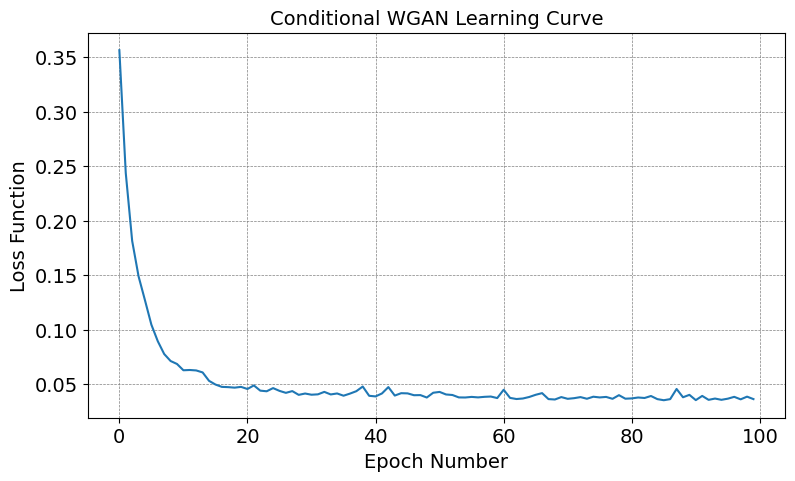

In [22]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(VAEFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [23]:
X_fake_train_vae = generate_with_vae(VAEFitter.decoder, y_train, latent_dim)
X_fake_train_vae_tr = qt.inverse_transform(X_fake_train_vae)
X_train_tr = qt.inverse_transform(X_train)

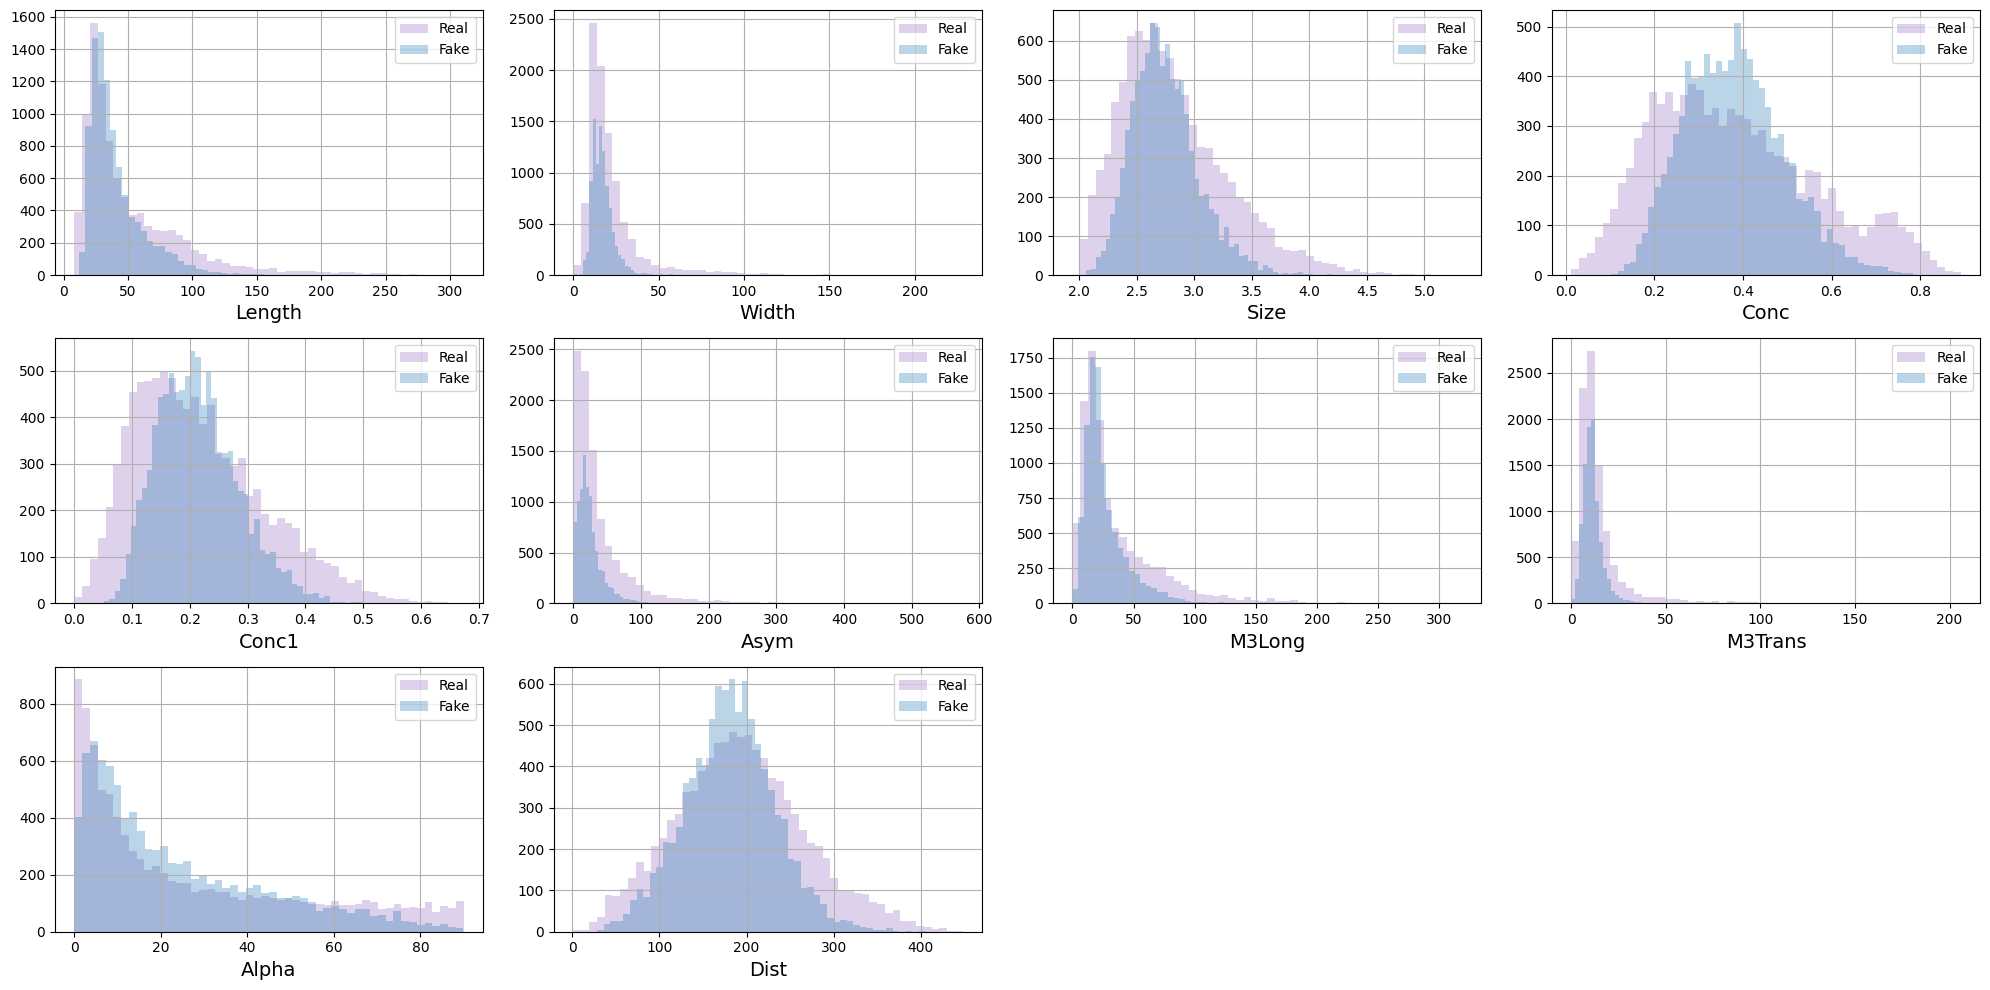

In [24]:
plot_hists(X_train_tr, X_fake_train_vae_tr, names, label1="Real", label2="Fake", bins=50)

In [25]:
X_fake_test_vae = generate_with_vae(VAEFitter.decoder, y_test, latent_dim)
X_fake_test_vae_tr = qt.inverse_transform(X_fake_test_vae)
X_test_tr = qt.inverse_transform(X_test)

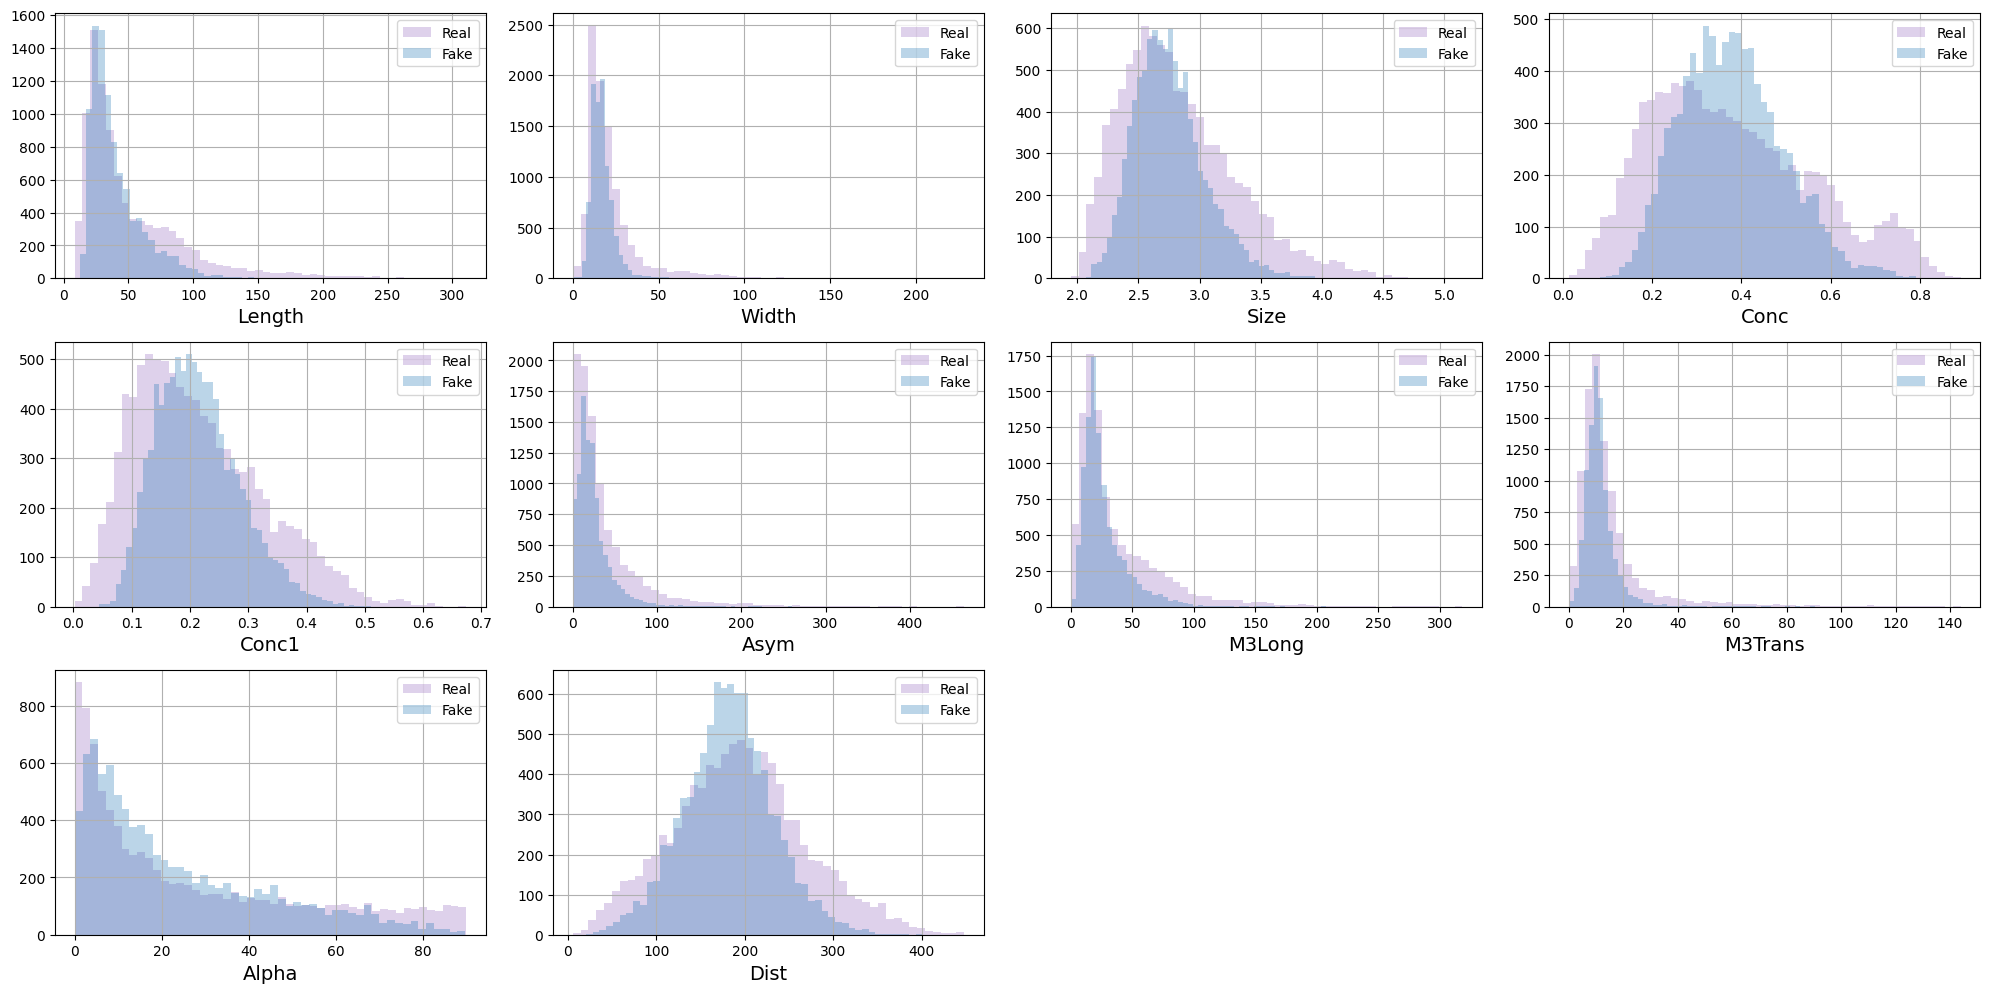

In [26]:
plot_hists(X_test_tr, X_fake_test_vae_tr, names, label1="Real", label2="Fake", bins=50)

In [27]:
XX_train_vae = np.concatenate((X_fake_train_vae, X_train), axis=0)
XX_test_vae = np.concatenate((X_fake_test_vae, X_test), axis=0)
yy_train = np.array([0] * len(X_fake_train_vae) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test_vae) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf_diffusion = GradientBoostingClassifier()
clf_diffusion.fit(XX_train_vae, yy_train)

yy_test_proba_vae = clf_diffusion.predict_proba(XX_test_vae)[:, 1]

In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score

auc_vae = roc_auc_score(yy_test, yy_test_proba_vae)
acc_vae = accuracy_score(yy_test, (yy_test_proba_vae >= 0.5).astype(int))

print("ROC AUC = ", auc_vae)
print("accuracy = ", auc_vae)

ROC AUC =  0.8150012881454134
accuracy =  0.8150012881454134
